In [19]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup

imp.reload(sp)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### Load in theta, boost, and F data

In [20]:
F_theta = sp.get_F(theta_dependence=True)
B_min1 = sp.get_boosts()
#B_min1 = np.load('generated_data/Boost_data_year1.npz')['B_min1']
theta = sp.theta_cents

Pk_gg calculated


KeyboardInterrupt: 

### Calculate maximum lensing residual

In [135]:
# define multiplicative bias uncertainty
sigma_m = 0.013

# set ell values based on theta range
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 180/(theta[0]/60.) + 10, 1024).astype(int))

# compute angular power spectrum for galaxy-galaxy lensing using H.O.D.s
Cl_gM, lensTracer, shearTracer = sp.get_LSST_Cl(ell, 'gm')

# compute lensing shear
y_L = ccl.correlation(sp.halo.cosmo_SRD, ell, Cl_gM, theta / 60., type='NG')

In [163]:
# multiply by maximum residual bias and divide by P.A. fraction
delM_yL = 2.*sigma_m*y_L / (B_min1 + F_theta)

### Calculate theoretical IA signal using L-NLA model

In [136]:
# load in redshift data
z_s, dndz_s, zseff = sp.zed.get_dndz_phot('source')
z_l, dndz_l, zleff = sp.zed.get_dndz_spec('lens')

# define IA model
f_red = 0.16
A_IA = 5.

IA_amps = f_red * A_IA * np.ones_like(z_s)

intrinsicTracer = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_s, dndz_s), has_shear=False, 
                                     ia_bias=(z_s, IA_amps))

# CALCULATE IA USING HALO MODEL POWER SPECTRUM

# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E2, 3000)

a_l = 1. / (1. + z_l)

# create 2D power spectrum objects for galaxy-IA correlation
pk_gMf = sp.halo.get_Pk2D('gm', k_arr, np.flip(a_l))

# compute aps for galaxy-intrinsic
Cl_IA = ccl.angular_cl(sp.zed.cosmo_SRD, lensTracer, intrinsicTracer, ell, p_of_k_a=pk_gMf)

In [164]:
# get IA tangential shear
y_IA = ccl.correlation(sp.zed.cosmo_SRD, ell, Cl_IA, theta / 60., type='NG')
bar_yIA = y_IA / (B_min1 + F_theta)

### Load in Y1 covariance matrix and combine with lensing residual 

In [21]:
# load in matrices and rho values
cov_file = np.load('generated_data/lsst-y1-covmats-IA.npz')
rho = cov_file['rho']
covs = cov_file['cov']

# add residual in quadrature to cov matrix
cov_IA = np.zeros_like(covs)
sigma_IA = np.zeros_like(covs[0])
for j in range(len(rho)):
    for i in range(len(theta)):
        for k in range(len(theta)):
            cov_IA[j,i,k] = (covs[j,i,k] / ((B_min1[i] + F_theta[i])*(B_min1[k] + F_theta[k]))) + delM_yL[i]*delM_yL[k]
    sigma_IA[j] = np.sqrt(np.diag(cov_IA[j,:,:]))

NameError: name 'theta' is not defined

In [153]:
# difference between sigma_IA for min and max rho values 
print(sigma_IA[0] - sigma_IA[8])

[1.16232136e-07 2.92429633e-07 3.52656979e-07 4.83799953e-07
 6.99123237e-07 1.11715334e-06 1.81335290e-06 2.74077829e-06
 3.49057163e-06 4.00517872e-06]


### Plot (1-0.5)yIA and (0.026)yL 

Text(0.5, 0, '$\\theta$ (arcmin)')

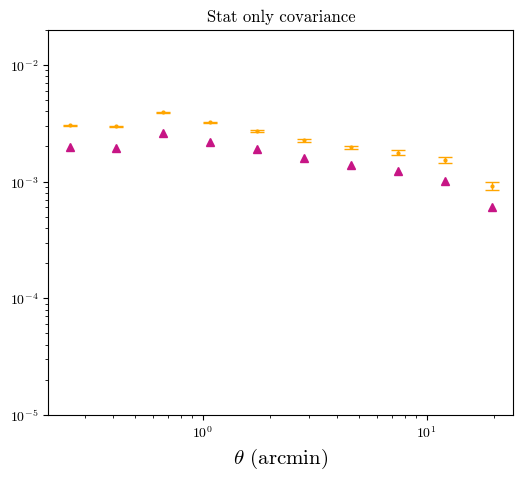

In [154]:
plt.figure(figsize=[6,5])
plt.errorbar(theta, -(1-0.5)*bar_yIA, np.sqrt(np.diag(covs[0])/(B_min1+F_theta)**2), linewidth=0, marker='o', markersize=2., color='orange',
            elinewidth=1., capsize=5.)
plt.plot(theta, delM_yL, linewidth=0, marker='^', color='mediumvioletred')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1E-5, 2E-2])
plt.title('Stat only covariance')
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)

### Plot (1-a)yIA for different a values

Text(0.5, 1.0, 'Stat+Sys Covariance, $\\rho=0.5$')

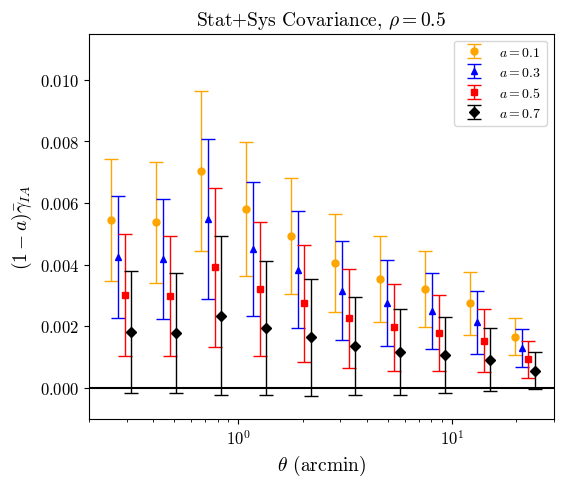

In [166]:
a = [0.1,0.3,0.5,0.7]
logshift = np.zeros([len(a),len(bar_yIA)])
yIA_1mina = np.zeros([len(a),len(bar_yIA)])
for i in range(len(a)):
    yIA_1mina[i,:] = -(1.-a[i]) * bar_yIA[:]
    logshift[i,:] = 0.08*theta*i

plt.figure(figsize=[6,5])
plt.errorbar(theta+logshift[0], yIA_1mina[0], sigma_IA[4], linewidth=0, marker='o', markersize=5., color='orange',
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[1], yIA_1mina[1], sigma_IA[4], linewidth=0, marker='^', markersize=5., color='blue',
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[2], yIA_1mina[2], sigma_IA[4], linewidth=0, marker='s', markersize=5., color='red',
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[3], yIA_1mina[3], sigma_IA[4], linewidth=0, marker='D', markersize=5., color='black',
            elinewidth=1., capsize=5.)
plt.legend([r'$a=%g$'%a[0],r'$a=%g$'%a[1],r'$a=%g$'%a[2],r'$a=%g$'%a[3]],)

plt.hlines(y=0.,xmin=0.1*theta.min(),xmax=1.6*theta.max(), color='black')
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.yscale('log')
plt.ylim([-1E-3, 1.15E-2])
plt.xlim(0.2,30)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}$', fontsize=14)
plt.title(r'Stat+Sys Covariance, $\rho=%g$'%(rho[4]), fontsize=14)